In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, concatenate,Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.applications as apps

In [2]:
image_dir = '/kaggle/input/waterset/data/images'
label_dir = '/kaggle/input/waterset/data/labels'

In [3]:

images = []
labels = []


for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.tif', '.png'))

    # Read multi-channel TIFF image using rasterio
    with rasterio.open(img_path) as src:
        img = src.read()  # Read all channels
        img = np.moveaxis(img, 0, -1)  # Move channel axis to the end

    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    # Normalize image (assumes data is in range [0, 255])
    img = img / 255.0

    # Read grayscale label image using OpenCV
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    if label is None:
        print(f"Failed to load label: {label_path}")
        continue

    # Binarize label
    label_binary = (label > 0).astype(np.uint8)

    # Append to lists
    images.append(img)
    labels.append(label_binary)

x = np.array(images)
y = np.array(labels)
y = np.expand_dims(y, axis=-1)  

print("x_train shape:", x.shape)
print("y_train shape:", y.shape)

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


x_train shape: (306, 128, 128, 12)
y_train shape: (306, 128, 128, 1)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2
)

datagen.fit(x_train)


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (214, 128, 128, 12) (12 channels).
  warnings.warn(


In [6]:
input_shape = (128, 128, 12)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6          
)


**Pretrained Model - DeepLabV3**

In [8]:
def get_deeplabv3_model(input_shape):
    # Define the custom input layer
    inputs = Input(shape=input_shape)  

    
    x = Conv2D(3, (1, 1), padding='same')(inputs)  

    
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',  # Pre-trained weights
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    
    x = base_model(x)

    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)  

    
    x = UpSampling2D(size=(32, 32))(x)  
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  

    
    model = Model(inputs=inputs, outputs=x)

    return model

In [9]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 12

In [10]:
pretrained_model = get_deeplabv3_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 256)      │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 1)    │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,397,352 (35.85 MB)

 Trainable params: 9,313,704 (35.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [13]:
pretrained_history = pretrained_model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_test, y_test),callbacks=[reduce_lr])

Epoch 1/20


I0000 00:00:1726168028.668294      65 service.cc:145] XLA service 0x7f006c0061a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726168028.668355      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726168092.823480      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_51', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_45', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_466', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1726168092.976265      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6149 - loss: 2.4882

I0000 00:00:1726168152.597672      64 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_slice_fusion_64', 8 bytes spill stores, 8 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.6192 - loss: 2.3567 - val_accuracy: 0.6385 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7963 - loss: 0.4745 - val_accuracy: 0.5842 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8476 - loss: 0.3786 - val_accuracy: 0.7208 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8474 - loss: 0.3577 - val_accuracy: 0.7715 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8694 - loss: 0.3091 - val_accuracy: 0.7412 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8788 - loss: 0.2916 - val_accuracy: 0.8120 - val_loss: 0.4639 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8809 - loss: 0.2814 - val_accuracy: 0.83

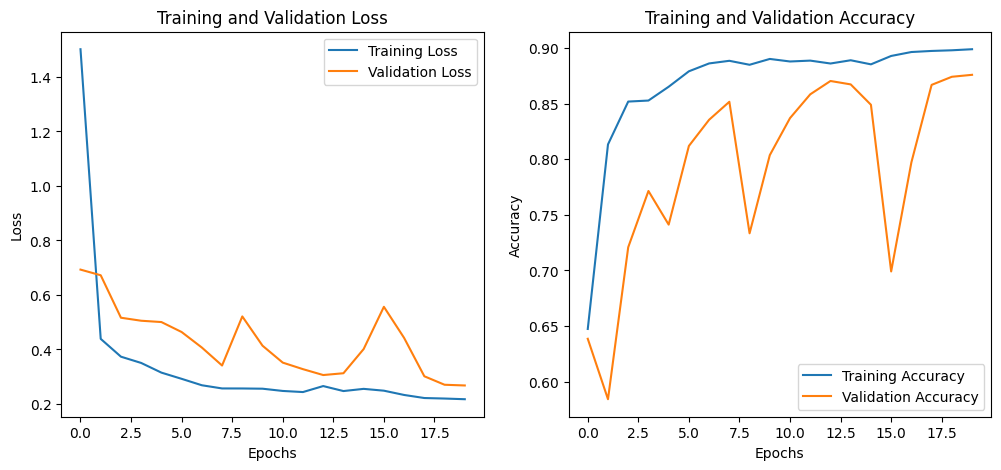

In [14]:
loss_acc_metrics_df = pd.DataFrame(pretrained_history.history)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_acc_metrics_df['loss'], label='Training Loss')
plt.plot(loss_acc_metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loss_acc_metrics_df['accuracy'], label='Training Accuracy')
plt.plot(loss_acc_metrics_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [15]:
loss, accuracy = pretrained_model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8744 - loss: 0.2735
Test Loss: 0.26776671409606934
Test Accuracy: 0.8759267926216125
